In [1]:
from keras.models import Sequential
import torch as tr
import numpy as np

from dualPM_torch import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### notes
- min trainable nback: stsize10,edim5,seqlen15,trepochs10k,thresh95,evalacc90


In [2]:
## task
nback=2
num_og_tokens=3
num_pm_trials = 1
seqlen = 15
## network
edim = 5
stsize = 10
batch=1
outdim=3
arch = 'purewm'

In [3]:
# model and task
if arch=='purewm':
  net = Net(edim,stsize,outdim)
elif arch=='wmem':
  net = Net_wmem(edim,stsize,outdim)
task = NBackPMTask(nback,num_og_tokens,num_pm_trials)
# specify loss and optimizer
lossop = tr.nn.CrossEntropyLoss()
optiop = tr.optim.Adam(net.parameters(), lr=0.005)

### train

In [4]:
thresh = .99
nepochs = 40000
L = -np.ones([nepochs])
A = -np.ones([nepochs])
E = -np.ones([nepochs])

acc = 0
nembeds = 0
Emat = tr.randn(num_og_tokens+1,edim)
for ep in range(nepochs):
  optiop.zero_grad() 
  # randomize emat
  if acc>thresh:
#     Emat = tr.randn(num_og_tokens+1,edim)
    Emat = tr.FloatTensor(num_og_tokens+1,edim).uniform_(0,1)
    nembeds+=1
  # generate data
  x_int,ytarget = task.gen_seq(seqlen)
  ytarget = tr.LongTensor(ytarget).unsqueeze(1)
  x_embeds = Emat[x_int].unsqueeze(1) 
  # forward prop
  yhat = net(x_embeds)
  # collect loss through time
  loss,acc = 0,0
  for yh,yt in zip(yhat,ytarget):
    loss += lossop(yh,yt)
    acc += yt==tr.argmax(tr.softmax(yh,1))
  acc = acc.numpy()/seqlen
  # bp and update
  loss.backward()
  optiop.step()
  epoch_loss = loss.item()
  L[ep] = epoch_loss
  A[ep] = acc
  E[ep] = nembeds

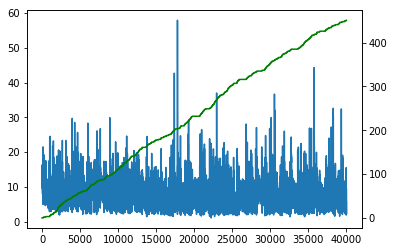

In [5]:
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(L)
ax2.plot(E,c='g')

### eval

In [6]:
seqlen = 15
neps = 500
score = -np.ones([neps,seqlen])

for ep in range(neps):
  # embedding matrix
  Emat = tr.FloatTensor(num_og_tokens+1,edim).uniform_(0,1)
  # generate data
  x_int,ytarget = task.gen_seq(seqlen,pm_trial_position=[5,9])
  ytarget = tr.LongTensor(ytarget).unsqueeze(1)
  # embed inputs
  x_embeds = Emat[x_int]
  x_embeds = x_embeds.unsqueeze(1)
  # forward prop
  yhat = net(x_embeds)
  ep_score = (ytarget == tr.softmax(yhat,-1).argmax(-1)).float().squeeze()
  score[ep] = ep_score 


In [ ]:
# np.save()

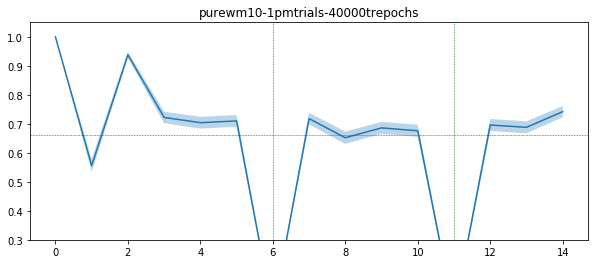

In [7]:
plt.figure(figsize=(10,4))
ax = plt.gca()
M = score.mean(0)
S = score.std(0)/np.sqrt(neps)
ax.plot(M)
ax.fill_between(range(seqlen),M-S,M+S,alpha=.3)
ax.set_ylim(0.3,1.05)
ax.axhline(.66,c='r',lw=.5,ls='--')
ax.axvline(6,c='g',lw=.5,ls='--')
ax.axvline(11,c='g',lw=.5,ls='--')
ax.set_xlabel('trial')
ax.set_ylabel('accuracy')
title = '%s%i-%ipmtrials-%itrepochs_eval'%(arch,stsize,num_pm_trials,nepochs)
plt.title(title)
plt.savefig('figures/wmem/'+title)